In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
# Riutilizziamo lo stesso dataset del precedente esempio
np.random.seed(42)


/Users/nuzzo2/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



t-SNE Distance Matrix:
            Tech Stocks     Banks Utilities  Consumer Real Estate    Energy
Tech Stocks         0.0  5.854829  7.807419  9.566341    6.658036  4.826828
Banks          5.854829       0.0  4.199363  9.092338    9.301854  5.118931
Utilities      7.807419  4.199363       0.0  5.547192    7.717764  3.949322
Consumer       9.566341  9.092338  5.547192       0.0    4.884935  4.917613
Real Estate    6.658036  9.301854  7.717764  4.884935         0.0  4.250137
Energy         4.826828  5.118931  3.949322  4.917613    4.250137       0.0

UMAP Distance Matrix:
            Tech Stocks      Banks  Utilities   Consumer Real Estate  \
Tech Stocks         0.0   8.970747  25.695286  17.128962   14.704379   
Banks          8.970747        0.0  33.642761  19.023556   23.298512   
Utilities     25.695286  33.642761        0.0  22.740105   20.552097   
Consumer      17.128962  19.023556  22.740105        0.0   26.630089   
Real Estate   14.704379  23.298512  20.552097  26.630089     

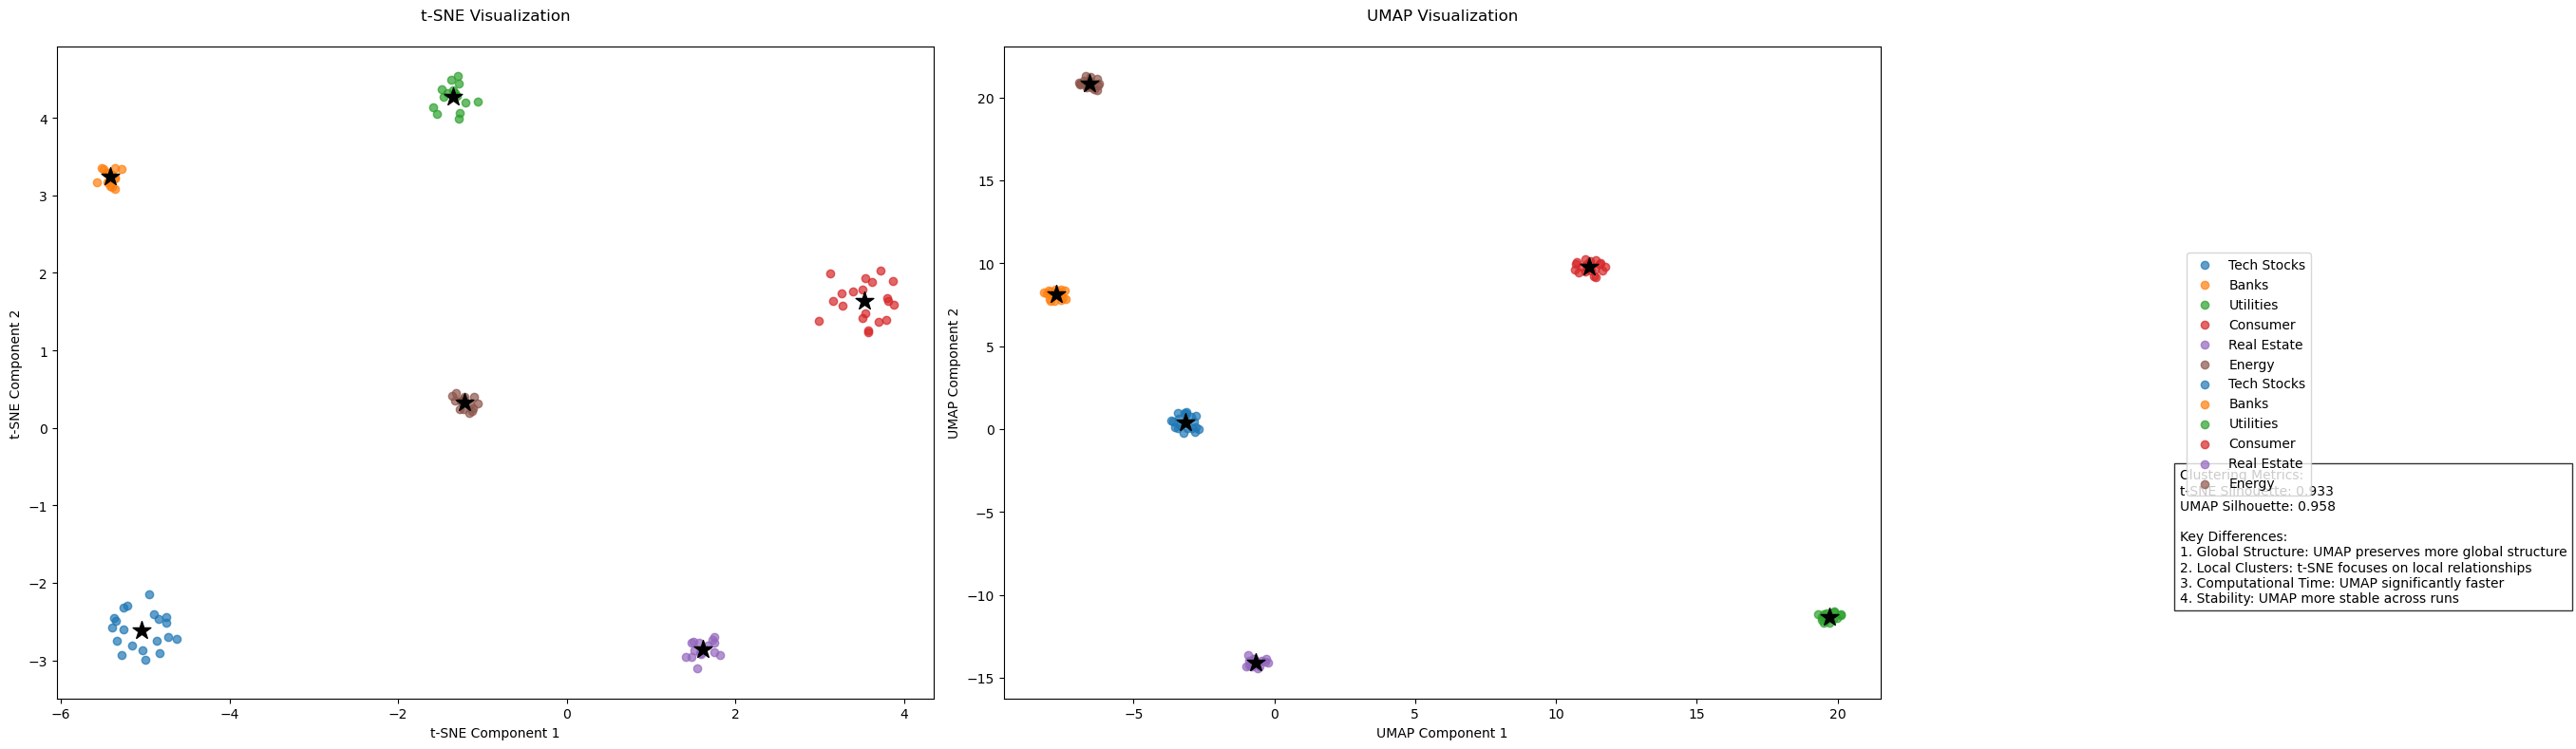

In [4]:

# Asset classes e loro caratteristiche
asset_classes = {
    'Tech Stocks': {'n': 20, 'volatility': 0.25, 'correlation': 0.7},
    'Banks': {'n': 15, 'volatility': 0.30, 'correlation': 0.8},
    'Utilities': {'n': 15, 'volatility': 0.15, 'correlation': 0.5},
    'Consumer': {'n': 20, 'volatility': 0.20, 'correlation': 0.6},
    'Real Estate': {'n': 15, 'volatility': 0.22, 'correlation': 0.65},
    'Energy': {'n': 15, 'volatility': 0.28, 'correlation': 0.75}
}

# Generazione dati come prima
n_days = 252
returns_data = []
labels = []

for asset_class, params in asset_classes.items():
    cov_matrix = np.ones((params['n'], params['n'])) * params['correlation']
    np.fill_diagonal(cov_matrix, 1)
    L = np.linalg.cholesky(cov_matrix)
    
    uncorrelated_returns = np.random.normal(0, params['volatility'], (n_days, params['n']))
    correlated_returns = np.dot(uncorrelated_returns, L.T)
    
    returns_data.append(correlated_returns)
    labels.extend([asset_class] * params['n'])

returns = np.hstack(returns_data)
returns_df = pd.DataFrame(returns, columns=[f'Asset_{i}' for i in range(len(labels))])

# Standardizzazione
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

# Applicare sia t-SNE che UMAP
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

tsne_results = tsne.fit_transform(returns_scaled.T)
umap_results = umap_reducer.fit_transform(returns_scaled.T)

# Creazione subplot per confronto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Color palette
palette = sns.color_palette("husl", len(asset_classes))
color_dict = dict(zip(asset_classes.keys(), palette))

# Plot t-SNE
for asset_class in asset_classes:
    mask = [l == asset_class for l in labels]
    ax1.scatter(tsne_results[mask, 0], 
                tsne_results[mask, 1],
                label=asset_class,
                alpha=0.7)

ax1.set_title('t-SNE Visualization', pad=20)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')

# Plot UMAP
for asset_class in asset_classes:
    mask = [l == asset_class for l in labels]
    ax2.scatter(umap_results[mask, 0], 
                umap_results[mask, 1],
                label=asset_class,
                alpha=0.7)

ax2.set_title('UMAP Visualization', pad=20)
ax2.set_xlabel('UMAP Component 1')
ax2.set_ylabel('UMAP Component 2')

# Legend comune
plt.figlegend(bbox_to_anchor=(1.15, 0.5), loc='center left')

# Analisi delle distanze per entrambi i metodi
def calculate_centroids_and_distances(embedding_results, labels, asset_classes):
    centroids = {}
    for asset_class in asset_classes:
        mask = [l == asset_class for l in labels]
        centroids[asset_class] = np.mean(embedding_results[mask], axis=0)
    
    distances = pd.DataFrame(index=asset_classes.keys(), columns=asset_classes.keys())
    for ac1 in asset_classes:
        for ac2 in asset_classes:
            dist = np.linalg.norm(centroids[ac1] - centroids[ac2])
            distances.loc[ac1, ac2] = dist
    
    return centroids, distances

tsne_centroids, tsne_distances = calculate_centroids_and_distances(tsne_results, labels, asset_classes)
umap_centroids, umap_distances = calculate_centroids_and_distances(umap_results, labels, asset_classes)

# Plot centroids
for ax, centroids in [(ax1, tsne_centroids), (ax2, umap_centroids)]:
    for asset_class, centroid in centroids.items():
        ax.scatter(centroid[0], centroid[1], 
                  marker='*', s=200, c='black')

# Aggiunta metriche di clustering
from sklearn.metrics import silhouette_score

tsne_silhouette = silhouette_score(tsne_results, labels)
umap_silhouette = silhouette_score(umap_results, labels)

analysis_text = f"""Clustering Metrics:
t-SNE Silhouette: {tsne_silhouette:.3f}
UMAP Silhouette: {umap_silhouette:.3f}

Key Differences:
1. Global Structure: UMAP preserves more global structure
2. Local Clusters: t-SNE focuses on local relationships
3. Computational Time: UMAP significantly faster
4. Stability: UMAP more stable across runs"""

plt.figtext(1.15, 0.2, analysis_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()

# Print distance matrices
print("\nt-SNE Distance Matrix:")
print(tsne_distances.round(2))
print("\nUMAP Distance Matrix:")
print(umap_distances.round(2))